In [1]:
import intro

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D

from sklearn.cluster import KMeans
from itertools import cycle
from sklearn_extra.cluster import KMedoids

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# temperature k-means
temp = pd.DataFrame(intro.signals.Amb_Temp_Avg)
temp_kmeans = KMeans(n_clusters=5, n_init=100).fit(temp)
temp_centroids = temp_kmeans.cluster_centers_
temp_centroids = np.sort(list(temp_centroids.flat))
print(f"Ambient temperature k-means centroids: {temp_centroids}")
print("Approximate middle values:")
for i in range(4):
    a = (temp_centroids[i] + temp_centroids[i + 1]) / 2
    print(a.round(0))
    
# temperature quantiles
tq = np.quantile(intro.signals.Amb_Temp_Avg, [0, 0.25, 0.5, 0.75, 1])
print(f"\nAmbient temperature quantiles: {tq}")

Ambient temperature k-means centroids: [12.47000126 16.40883334 20.96756013 25.72632718 31.14864429]
Approximate middle values:
14.0
19.0
23.0
28.0

Ambient temperature quantiles: [ 4. 16. 19. 24. 41.]


In [3]:
def aging_centroids(df, wind_seg, temp_seg, method=1):
    """
    Input:
    df = wind turbine
    wind_seg = wind segment code (1-10, see intro.py for more details)
    temp_seg = ambient temperature segment (0-3)
    method = temperature segmentation approach (1 = k-means, 2 = quantiles)
    
    Output:
    List of data frames including:
    X_centroids = turbine data centroids with 3 clusters (low, middle and high active power)
    X_centroids_centers = central points of each cluster
    """
    
    # method: 1 = temp. k-means, 2 = temp. quantiles
    if method == 1:
        tmp = temp_centroids
    if method == 2:
        tmp = tq
    
    # data cleaning (remove anomalies, focus on operating region)
    df = df[(df.Prod_LatestAvg_TotActPwr > 0) & (df.Grd_Prod_Pwr_Avg > 0) &
            (df.Amb_WindSpeed_Avg >= 4) & (df.Amb_WindSpeed_Avg < 9) & (df.Prod_LatestAvg_TotActPwr <= 200000)]
    df = df.reset_index(drop=True)
    
    # select wind segment (1-10)
    df = df[df.Wind_Segment_Code == wind_seg]
    
    # select amb. temp. segment (0-3)
    df = df[(df.Amb_Temp_Avg >= tmp[temp_seg]) & (df.Amb_Temp_Avg < tmp[temp_seg + 1])]
    
    # select active power variable and add lag variable (change of power)
    X = pd.DataFrame(df.loc[:, "Prod_LatestAvg_TotActPwr"])
    X["Pwr_Change"] = X.diff()
    X = X.iloc[1:, :] # remove NA (first row)
    
    # further partition
    N = 70  # data chunk row size
    X_list = [X[i:i+N] for i in range(0, X.shape[0], N)]
    # delete last chunk if not enough observations (70 %)
    if X_list[len(X_list) - 1].shape[0] < 0.7 * N:
        del X_list[len(X_list) - 1]
        
    # k-medoids on partitions
    X_centroids = np.empty([1, 2])
    for i in range(len(X_list)):
        km = KMedoids(n_clusters=3, method="pam", init="build", max_iter=1000)
        X_list[i]["cluster"] = km.fit_predict(X_list[i])
        X_centroids = np.concatenate((X_centroids, np.sort(km.cluster_centers_, axis=0)))
        
    X_centroids = pd.DataFrame(np.delete(X_centroids, 0, axis=0), columns=["Prod_LatestAvg_TotActPwr", "Pwr_Change"])
    
    # add cluster column to sorted centroids
    CLUSTERS = cycle([0, 1, 2])
    X_centroids['cluster'] = [next(CLUSTERS) for c in range(len(X_centroids))]
    
    # compute central points of each cluster (based on median)
    X_centroids_centers = pd.DataFrame(columns=["Prod_LatestAvg_TotActPwr", "Pwr_Change"])
    for i in range(3):
        m = X_centroids[X_centroids.cluster == i].median()
        X_centroids_centers = X_centroids_centers.append(m, ignore_index=True)
    
    return [X_centroids, X_centroids_centers]

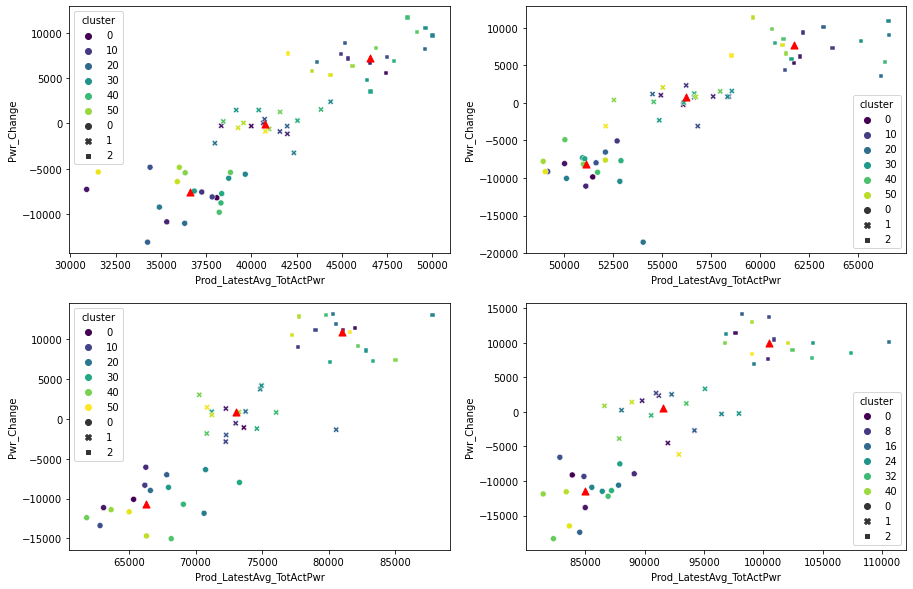

In [10]:
# select turbine for testing
turbine = intro.signals_T06

# set wind and temperature segments
ac1 = aging_centroids(turbine, 3, 0)
ac2 = aging_centroids(turbine, 4, 0)
ac3 = aging_centroids(turbine, 5, 0)
ac4 = aging_centroids(turbine, 6, 0)

# raw plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(x="Prod_LatestAvg_TotActPwr", y="Pwr_Change", style="cluster", data=ac1[0], hue=ac1[0].index, palette="viridis", ax=ax1)
sns.scatterplot(x="Prod_LatestAvg_TotActPwr", y="Pwr_Change", style="cluster", data=ac2[0], hue=ac2[0].index, palette="viridis", ax=ax2)
sns.scatterplot(x="Prod_LatestAvg_TotActPwr", y="Pwr_Change", style="cluster", data=ac3[0], hue=ac3[0].index, palette="viridis", ax=ax3)
sns.scatterplot(x="Prod_LatestAvg_TotActPwr", y="Pwr_Change", style="cluster", data=ac4[0], hue=ac4[0].index, palette="viridis", ax=ax4)

ax1.scatter(ac1[1].iloc[:, 0], ac1[1].iloc[:, 1], color="red", marker="^", s=50)
ax2.scatter(ac2[1].iloc[:, 0], ac2[1].iloc[:, 1], color="red", marker="^", s=50)
ax3.scatter(ac3[1].iloc[:, 0], ac3[1].iloc[:, 1], color="red", marker="^", s=50)
ax4.scatter(ac4[1].iloc[:, 0], ac4[1].iloc[:, 1], color="red", marker="^", s=50)

In [11]:
def dist_diff(ac, cluster):
    """
    Input:
    ac = list of data frames obtained from aging_centroids() function
    cluster = centroids cluster {0, 1, 2}
    
    Output:
    D = difference between mean distances of newest and oldest centroids from central points (red triangles)
    """
    
    clustered_centroids = ac[0][ac[0].cluster == cluster].reset_index(drop=True)
    distances = []
    
    for i in range(len(clustered_centroids)):
        distances.append(np.linalg.norm(np.array(clustered_centroids.iloc[i, :2]) - np.array(ac[1].iloc[cluster, :2])))
        
    distances = pd.DataFrame(distances, columns=["distance"])
    
    # middle index of distances data frame
    mid = int(np.median(list(distances.index)))
    
    oldest_distances = distances.iloc[:mid, :] # first half = oldest timestamps (indigo)
    newest_distances = distances.iloc[mid:, :] # second half = newest timestamps (yellow)
    
    mean_newest_dist = newest_distances.mean()
    mean_oldest_dist = oldest_distances.mean()
    
    D = np.round(float(mean_newest_dist - mean_oldest_dist), 2)
        
    return D

In [19]:
dist_diff(ac2, cluster=2)

-997.35

In [30]:
ac_list = [ac1, ac2, ac3, ac4]
D = 0

for el in ac_list:
    print("\n")
    for k in range(3):
        D_k = dist_diff(el, cluster=k)
        print("D_" + str(k) + " = " + str(D_k))
        D = D + D_k
    print("---------------")
    print("D = " + str(np.round(D/3, 2)))



D_0 = -619.33
D_1 = 302.71
D_2 = 1009.48
---------------
D = 230.95


D_0 = -1332.26
D_1 = 509.36
D_2 = -997.35
---------------
D = -375.8


D_0 = 854.45
D_1 = -360.65
D_2 = 995.68
---------------
D = 120.7


D_0 = -486.38
D_1 = 1412.46
D_2 = -462.29
---------------
D = 275.29


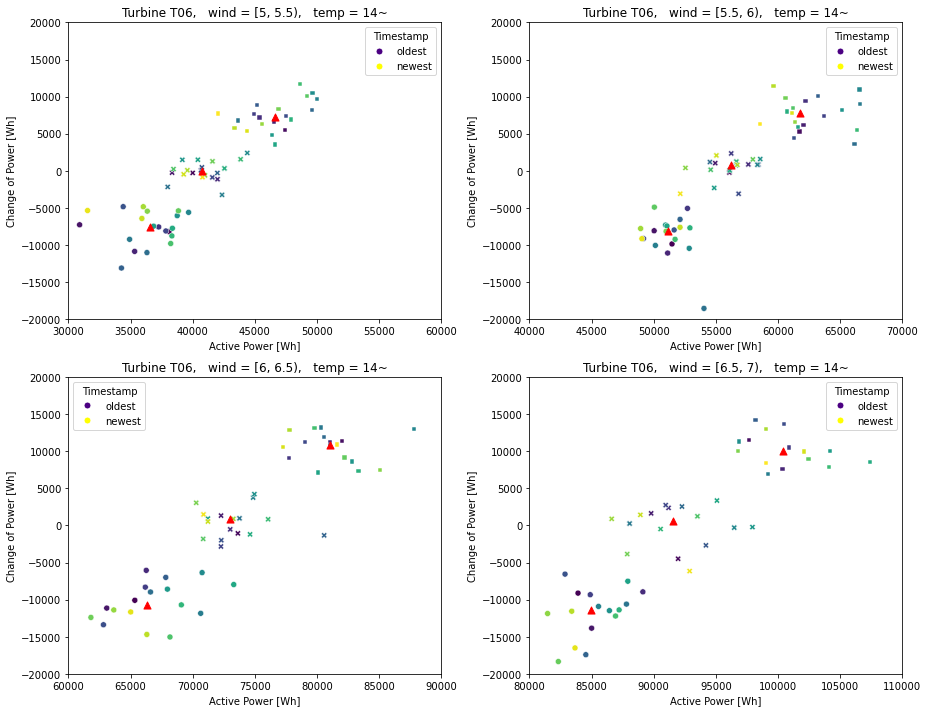

In [9]:
# final results plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13, 10))

sns.scatterplot(x="Prod_LatestAvg_TotActPwr", y="Pwr_Change", style="cluster", data=ac1[0], hue=ac1[0].index, palette="viridis", ax=ax1)
sns.scatterplot(x="Prod_LatestAvg_TotActPwr", y="Pwr_Change", style="cluster", data=ac2[0], hue=ac2[0].index, palette="viridis", ax=ax2)
sns.scatterplot(x="Prod_LatestAvg_TotActPwr", y="Pwr_Change", style="cluster", data=ac3[0], hue=ac3[0].index, palette="viridis", ax=ax3)
sns.scatterplot(x="Prod_LatestAvg_TotActPwr", y="Pwr_Change", style="cluster", data=ac4[0], hue=ac4[0].index, palette="viridis", ax=ax4)

ax1.scatter(ac1[1].iloc[:, 0], ac1[1].iloc[:, 1], color="red", marker="^", s=50)
ax2.scatter(ac2[1].iloc[:, 0], ac2[1].iloc[:, 1], color="red", marker="^", s=50)
ax3.scatter(ac3[1].iloc[:, 0], ac3[1].iloc[:, 1], color="red", marker="^", s=50)
ax4.scatter(ac4[1].iloc[:, 0], ac4[1].iloc[:, 1], color="red", marker="^", s=50)

ax1.set_xlabel("Active Power [Wh]")
ax1.set_ylabel("Change of Power [Wh]")
ax2.set_xlabel("Active Power [Wh]")
ax2.set_ylabel("Change of Power [Wh]")
ax3.set_xlabel("Active Power [Wh]")
ax3.set_ylabel("Change of Power [Wh]")
ax4.set_xlabel("Active Power [Wh]")
ax4.set_ylabel("Change of Power [Wh]")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='oldest', markerfacecolor='indigo', markersize=7),
                  Line2D([0], [0], marker='o', color='w', label='newest', markerfacecolor='yellow', markersize=7)]

ax1.legend(handles=legend_elements, title="Timestamp")
ax2.legend(handles=legend_elements, title="Timestamp")
ax3.legend(handles=legend_elements, title="Timestamp")
ax4.legend(handles=legend_elements, title="Timestamp")

# ------------------------------ fix manually ------------------------------
ax1.set_xlim(30000, 60000)
ax2.set_xlim(40000, 70000)
ax3.set_xlim(60000, 90000)
ax4.set_xlim(80000, 110000)

ax1.set_ylim(-20000, 20000)
ax2.set_ylim(-20000, 20000)
ax3.set_ylim(-20000, 20000)
ax4.set_ylim(-20000, 20000)

ax1.set_title("Turbine T06,   wind = [5, 5.5),   temp = 14~")
ax2.set_title("Turbine T06,   wind = [5.5, 6),   temp = 14~")
ax3.set_title("Turbine T06,   wind = [6, 6.5),   temp = 14~")
ax4.set_title("Turbine T06,   wind = [6.5, 7),   temp = 14~")
# --------------------------------------------------------------------------

fig.tight_layout()

plt.savefig("../img/aging")